## A/B Testing Analysis: E-commerce Checkout Optimization

This notebook demonstrates a comprehensive A/B testing analysis for optimizing 
an e-commerce checkout process. 

**Table Of Content**

1. Introduction and Problem Statement
2. Experimental Design and Power Analysis
3. Exploratory Data Analysis
4. Metric Analysis
5. Segmentation Analysis
6. Recommendations and Next Steps

##  1. Setup and Introduction

In [45]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import importlib
import utils
importlib.reload(utils)

import warnings
warnings.filterwarnings('ignore')

# Set styling
#plt.style.use('seaborn-v0_8')
#sns.set_palette("husl")
pd.set_option('display.expand_frame_repr', False) # Prevents line breaks in DataFrame display


## 2: Problem Statement and Experimental Design

### 2.1. Problem Statement 

#### Business Challenge
Our e-commerce platform has a **68% checkout abandonment rate**, costing an estimated 
**$2.3M annually** in lost revenue. The current 4-step checkout process is too complex 
and causes friction for users, especially on mobile devices.

#### Hypothesis
**H₀**: The new streamlined checkout design has no effect on conversion rate \
**H₁**: The new streamlined checkout design increases conversion rate by at least 2%

#### Test Design
- **Control (A)**: Original 4-step checkout process
- **Treatment (B)**: Streamlined 2-step checkout with progress indicators
- **Primary Metric**: Conversion rate (purchases/sessions)
- **Secondary Metrics**: Revenue per session
- **Traffic Split**: 50/50 randomized assignment

#### Success Criteria
- Minimum 2% absolute increase in conversion rate
- Statistical significance (p < 0.05)
- No decrease in average order value
- Business impact > $500000 annually

### 2.2. Key Parameters

In [46]:
baseline_conversion_rate = 0.10  # Current conversion rate
min_defectable_effect = 0.02  # 2% absolute increase
alpha = 0.05  # Significance level
power = 0.80  # Statistical power
current_daily_traffic = 470  # Daily traffic to the site

print(f" Experimental Parameters:")
print(f" Baseline conversion rate: {baseline_conversion_rate:.1%}")
print(f" Minimum detectable effect: {min_defectable_effect:.1%}")
print(f" Significance level: {alpha}")
print(f" Statistical power: {power}")
print(f" Current Daily traffic: {current_daily_traffic} visitors/day")

 Experimental Parameters:
 Baseline conversion rate: 10.0%
 Minimum detectable effect: 2.0%
 Significance level: 0.05
 Statistical power: 0.8
 Current Daily traffic: 470 visitors/day



### 2.3 Analysis and Sample Size Calculation

In [47]:
# Calculate required sample size
sample_size_per_group = utils.calculate_sample_size(
    baseline_conversion_rate, min_defectable_effect, alpha, power
)

test_duration_needed = (sample_size_per_group * 2) // current_daily_traffic
# Display results
print(f"Sample Size Analysis:")
print(f"Required sample size per group: {sample_size_per_group:,}")
print(f"Total required sample size: {sample_size_per_group * 2:,}")
print(f"Test Duration Needed (minimum): {test_duration_needed:,} days")

Sample Size Analysis:
Required sample size per group: 3,843
Total required sample size: 7,686
Test Duration Needed (minimum): 16 days


#### Power curve visualization

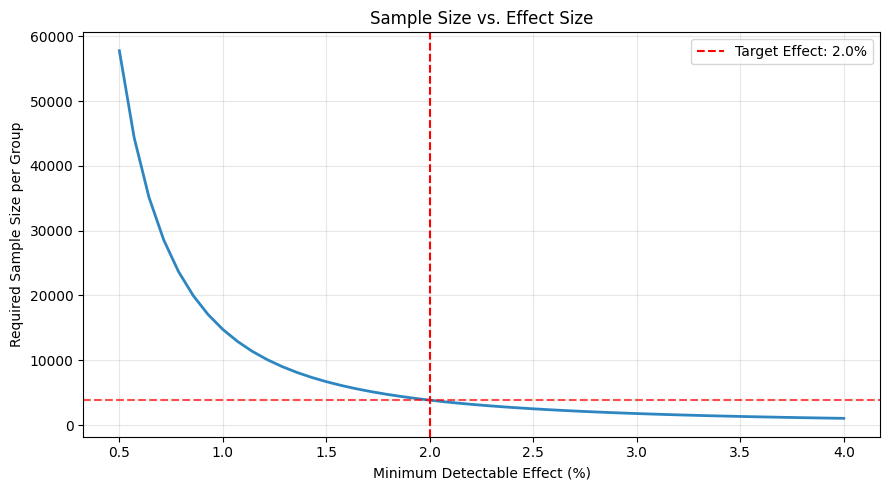

In [48]:
# Power curve visualization
effect_sizes = np.linspace(0.005, 0.04, 50)
sample_sizes = [utils.calculate_sample_size(baseline_conversion_rate, effect, alpha, power) 
                for effect in effect_sizes]

plt.figure(figsize=(9, 5))
plt.plot(effect_sizes * 100, sample_sizes, linewidth=2, color='#2E86C1')
plt.axvline(min_defectable_effect * 100, color='red', linestyle='--', 
            label=f'Target Effect: {min_defectable_effect:.1%}')
plt.axhline(sample_size_per_group, color='red', linestyle='--', alpha=0.7)
plt.xlabel('Minimum Detectable Effect (%)')
plt.ylabel('Required Sample Size per Group')
plt.title('Sample Size vs. Effect Size')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


## 3 Data Quality Checks

Before analyzing results, we must validate our experiment data for common issues which might affect the analysis.\
\
**Sample Ratio Mismatch**: Data split betweeen control and treatment should not be much different from expected split.\
**Data Completeness**: Checks for missing values, outliers, and data consistency.\
**Randomization Check**: Verifies that user characteristics are balanced between groups.

#### 3.1 Getting Data

In [49]:
# Read the dataset
df = pd.read_csv('data/ab_test_data.csv')
df.head()

,user_id,variant,device_type,user_type,traffic_source,converted,order_value
0,control_0,control,mobile,returning_user,direct,0,0.000000
1,control_1,control,mobile,new_user,organic,0,0.000000
2,control_2,control,desktop,returning_user,organic,1,120.120484
3,control_3,control,mobile,new_user,paid,0,0.000000
4,control_4,control,mobile,returning_user,organic,0,0.000000


### 3.2 Check Sample Size
This makes sure number of samples in each group exceeds the required sample size. There are 4957 users in control group and 5043 users in treatment group which is significant larger than required number, so the sample size requirement meets.

In [50]:
df.groupby('variant').agg({'user_id': 'count'}).rename(columns={'user_id': 'count'}).reset_index()

,variant,count
0,control,4957
1,treatment,5043


#### 3.3 Sample Ratio Mismatch (SRM)
Ensures the traffic split is as expected (50/50) before doing analysis. SRM protects us from making business decisions based on flawed data. Deviations can come froms various sources:
- Technical issues: randomization algorithm bugs, client-side tracking failures
- Selection bias: geographic or temporal biases in assignment
- Data collection problems: missing data from one variant, logging errors

In [51]:
# Expected ratio of control to treatment
expected_ratio = 0.5 
detection_sensitivity = 0.1 # Sensitivity for detecting sample ratio mismatch, higher values indicate more sensitivity, stricter checks

# Calculate observed counts and expected counts
variant_counts = df['variant'].value_counts()
control_count = variant_counts.get('control', 0)
treatment_count = variant_counts.get('treatment', 0)
total = control_count + treatment_count

expected_control = total * expected_ratio
expected_treatment = total * (1 - expected_ratio)

# Chi-square test
chi2_stat = ((control_count - expected_control)**2 / expected_control + 
(treatment_count - expected_treatment)**2 / expected_treatment)
p_value = 1 - stats.chi2.cdf(chi2_stat, df=1)

print(f"   Sample Ratio Mismatch Check:")
print(f"   Control: {control_count:,} ({control_count/total:.1%})")
print(f"   Treatment: {treatment_count:,} ({treatment_count/total:.1%})")
print(f"   Expected split: {expected_ratio:.1%} / {1-expected_ratio:.1%}")
print(f"   Chi-square statistic: {chi2_stat:.4f}")
print(f"   P-value: {p_value:.6f}")
print(f"   Result: {'✅ PASS' if p_value > detection_sensitivity else '❌ FAIL - INVESTIGATE'}")

   Sample Ratio Mismatch Check:
   Control: 4,957 (49.6%)
   Treatment: 5,043 (50.4%)
   Expected split: 50.0% / 50.0%
   Chi-square statistic: 0.7396
   P-value: 0.389789
   Result: ✅ PASS


In [52]:
df.groupby('variant').agg({'converted': 'sum'})

,converted
variant,
control,511
treatment,737


#### 3.3 Data Completeness Check

In [53]:
# Check for missing data
print(f"\n📊 Data Completeness Check:")
missing_data = df.isnull().sum()
print(f"   Missing values per column:")
for col, missing in missing_data.items():
    print(f"   {col}: {missing} ({missing/len(df):.1%})")


📊 Data Completeness Check:
   Missing values per column:
   user_id: 0 (0.0%)
   variant: 0 (0.0%)
   device_type: 0 (0.0%)
   user_type: 0 (0.0%)
   traffic_source: 0 (0.0%)
   converted: 0 (0.0%)
   order_value: 0 (0.0%)


The data is clean, no missing entries, it is ready to moveforward.

#### 3.4 Randomization Check
Verifies that user characteristics are balanced between groups.

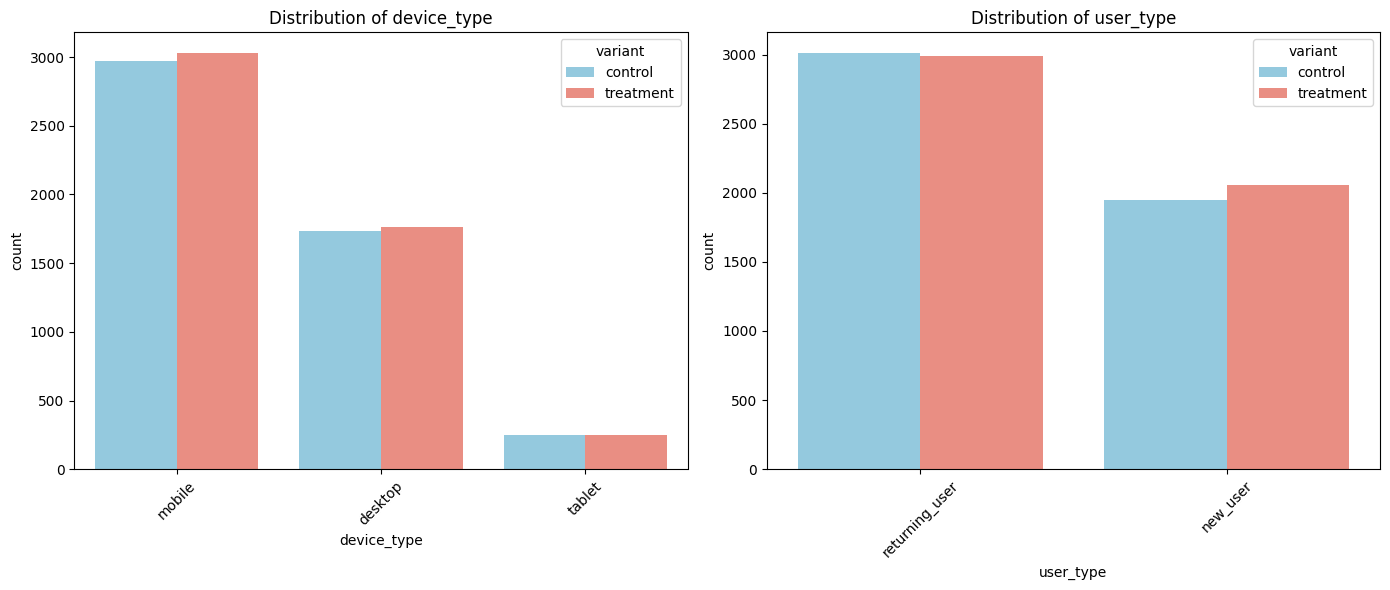

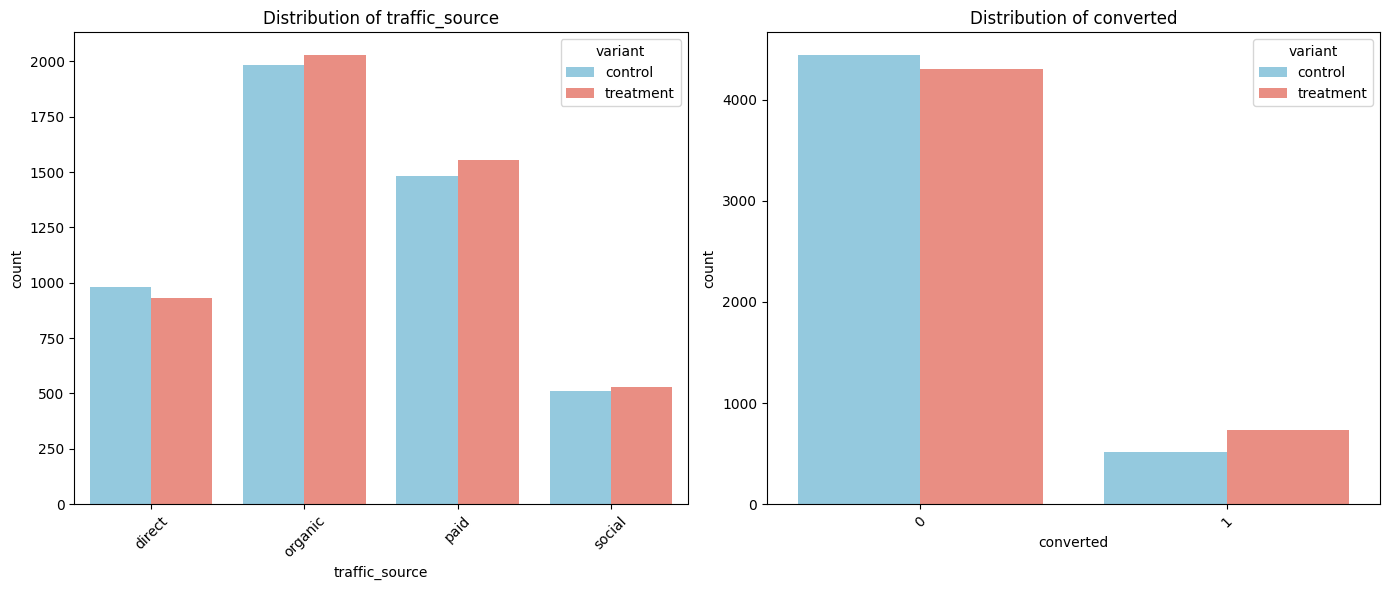

In [54]:
def plot_categorical_distributions(df, columns):
    for i in range(0, len(columns), 2):
        batch = columns[i:i+2]
        fig, axes = plt.subplots(1, len(batch), figsize=(14, 6))
        
        if len(batch) == 1:
            axes = [axes]  # Convert to list if only one axis
            
        for j, col in enumerate(batch):
            sns.countplot(data=df, x=col, hue="variant", ax=axes[j], 
                         palette={'control': 'skyblue', 'treatment': 'salmon'})
            axes[j].set_title(f'Distribution of {col}')
            axes[j].tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.show()
# Plot categorical distributions
plot_categorical_distributions(df, columns=['device_type', 'user_type', 'traffic_source','converted'])

#### 3.5 Box plot for extreme values

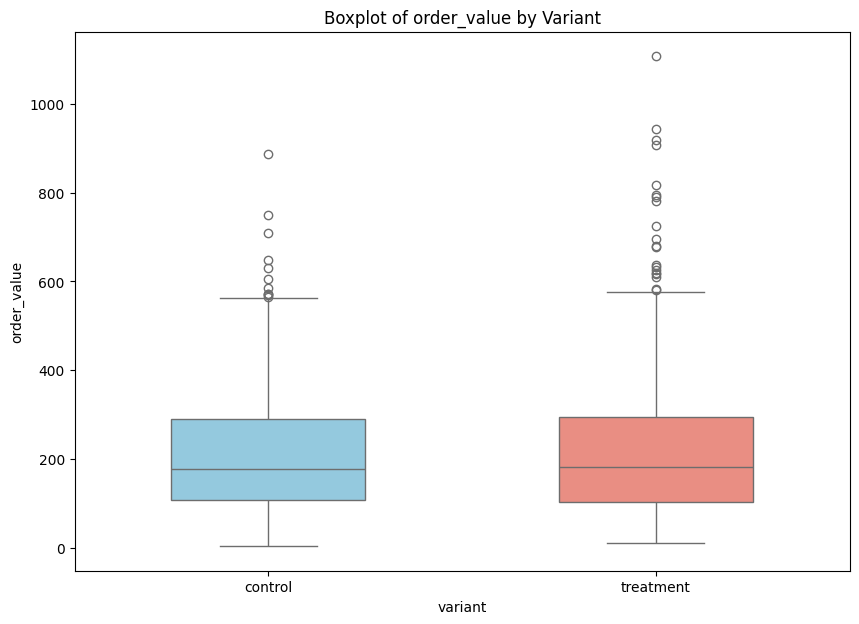

In [55]:
# use only rows with converted == 1
df_converted = df[df['converted'] == 1]

# make boxplots for numerical variables
def plot_boxplots(df, columns):
    for i in range(0, len(columns), 2):
        batch = columns[i:i+2]
        fig, axes = plt.subplots(1, len(batch), figsize=(10, 7))
        
        if len(batch) == 1:
            axes = [axes]  # Convert to list if only one axis
            
        for j, col in enumerate(batch):
            sns.boxplot(data=df, x = 'variant',y=col, ax=axes[j], hue="variant",
                       palette={'control': 'skyblue', 'treatment': 'salmon'}, width=0.5)
            axes[j].set_title(f'Boxplot of {col} by Variant')
        
        #plt.tight_layout()
        plt.show()
# Plot boxplots for numerical variables
print()
plot_boxplots(df_converted, columns=['order_value'])

#### 3.6 Numerical Feature Distribution

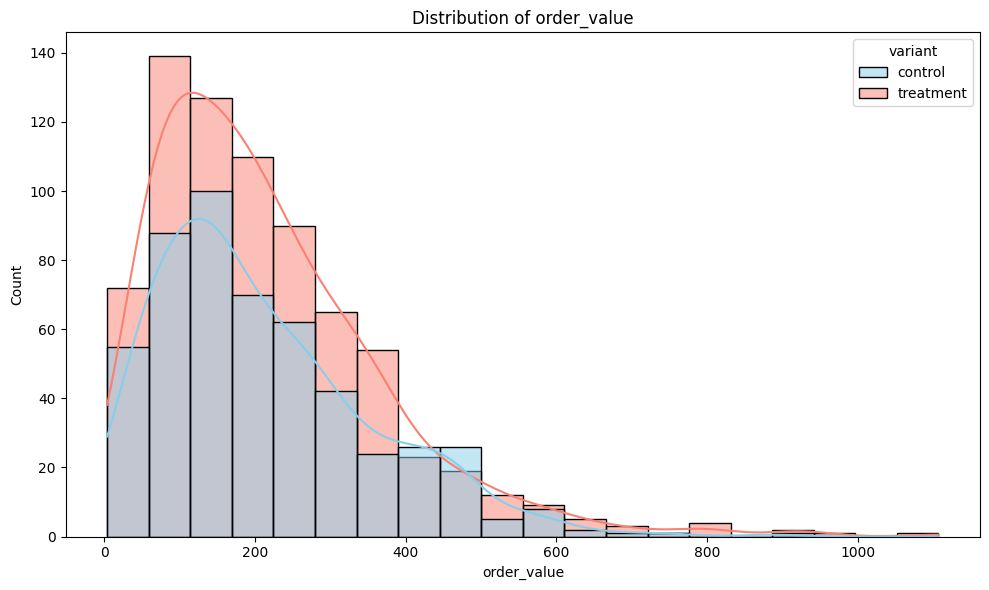

In [56]:
# use only rows with converted == 1
df_converted = df[df['converted'] == 1]

def plot_numerical_distributions(df, columns):
    for i in range(0, len(columns), 3):
        batch = columns[i:i+3]
        fig, axes = plt.subplots(1, len(batch), figsize=(10, 6))
        
        if len(batch) == 1:
            axes = [axes]  # Convert to list if only one axis
            
        for j, col in enumerate(batch):
            sns.histplot(df, x=col, hue="variant", kde=True, ax=axes[j], bins=20, 
                        palette={'control': 'skyblue', 'treatment': 'salmon'})
            axes[j].set_title(f'Distribution of {col}')
        
        plt.tight_layout()
        plt.show()
# Plot distributions of numerical variables
plot_numerical_distributions(df_converted, columns=['order_value'])

## 4. Statistical Analysis 

The primary metric is **conversion rate** - the percentage of users who complete a purchase.
This is our key business metric and the main outcome we're trying to improve.

#### Statistical Tests Applied:
- **Two-proportion z-test**: Tests if conversion rates differ significantly
- **Confidence intervals**: Provides range of plausible values for the true effect
- **Effect size calculations**: Measures practical significance


🎯 PRIMARY METRIC: CONVERSION RATE

📊 Statistical Test Results:
   Control conversion rate:    10.309%
   Treatment conversion rate:  14.614%
   95% CI Control:             [9.462%, 11.155%]
   95% CI Treatment:           [13.639%, 15.589%]

🎯 Effect Size:
   Absolute lift:              +4.306%
   Relative lift:              +41.8%
   Absolute lift CI:           3.014% to 5.597%

🧪 Statistical Significance:
   Z-statistic:                6.5138
   P-value:                    0.000000
   Significant (α=0.05):       ✅ YES
   Observed power:             100.0%
💰 Revenue Per User:
   Control:                    $21.79
   Treatment:                  $31.56
   Revenue lift:               44.79%


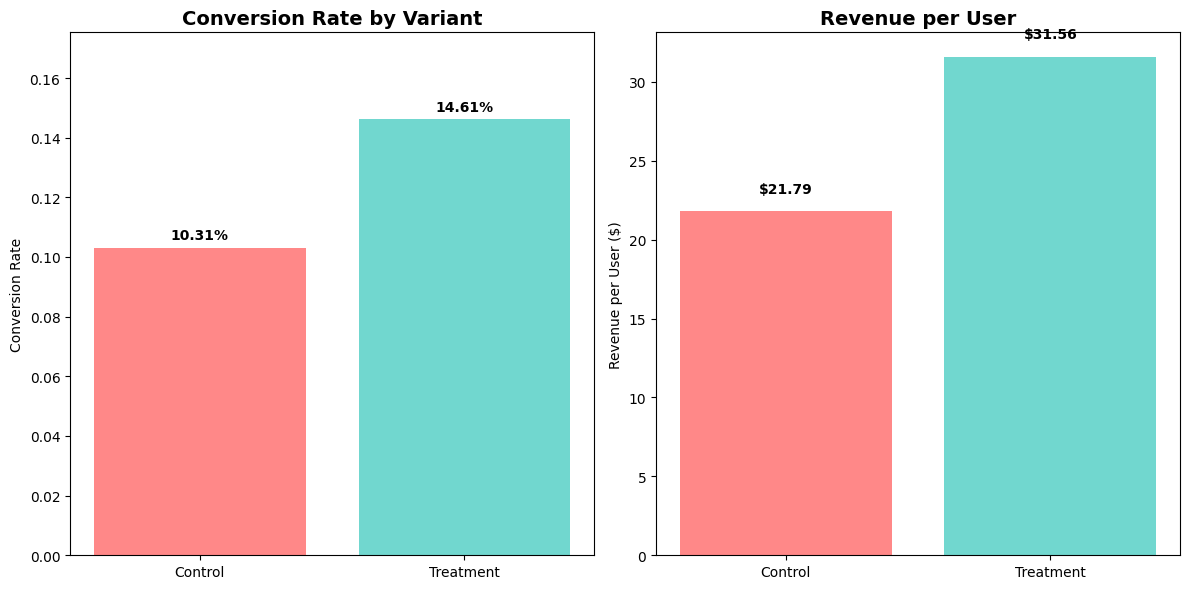

In [57]:

# Run conversion rate analysis
conversion_results, conv_p_value, abs_lift, rel_lift = utils.analyze_conversion_rate(df)


# Conversion rates with confidence intervals
variants = ['Control', 'Treatment']
rates = [conversion_results.loc['control', 'conversion_rate'], 
         conversion_results.loc['treatment', 'conversion_rate']]


# Revenue per user
rpu_values = [conversion_results.loc['control', 'revenue_per_user'], 
              conversion_results.loc['treatment', 'revenue_per_user']]
annual_revenue_lift = (conversion_results.loc['treatment', 'total_revenue'] - conversion_results.loc['control', 'total_revenue'])*365/21

# Visualization of conversion rates
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

colors = ['#FF6B6B', '#4ECDC4']
bars = ax1.bar(variants, rates, color=colors, alpha=0.8, capsize=5)
ax1.set_title('Conversion Rate by Variant', fontsize=14, fontweight='bold')
ax1.set_ylabel('Conversion Rate')
ax1.set_ylim(0, max(rates) * 1.2)

# Add value labels
for bar, rate in zip(bars, rates):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002, 
            f'{rate:.2%}', ha='center', va='bottom', fontweight='bold')

bars2 = ax2.bar(variants, rpu_values, color=colors, alpha=0.8)
ax2.set_title('Revenue per User', fontsize=14, fontweight='bold')
ax2.set_ylabel('Revenue per User ($)')

for bar, rpu in zip(bars2, rpu_values):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
            f'${rpu:.2f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()


## 5. Segmentation Analysis 

Understanding how different user segments respond to the treatment helps us to identify which user group have most effects from the changes. So we can optimize future iterations for specific segments. We'll analyze performance across:
- **Device type**: Mobile, desktop, tablet users
- **User type**: New vs. returning users
- **Traffic source**: How users arrived at the site


📱 SEGMENTATION ANALYSIS: DEVICE_TYPE
mobile       | Control: 8.8% | Treatment: 12.9% | Lift: +46.6% | p=0.000 | ✅ SIG
desktop      | Control: 13.2% | Treatment: 18.0% | Lift: +36.3% | p=0.000 | ✅ SIG
tablet       | Control: 8.1% | Treatment: 11.3% | Lift: +40.0% | p=0.224 | ❌ NS

📱 SEGMENTATION ANALYSIS: USER_TYPE
returning_user | Control: 11.0% | Treatment: 15.6% | Lift: +41.9% | p=0.000 | ✅ SIG
new_user     | Control: 9.3% | Treatment: 13.2% | Lift: +42.4% | p=0.000 | ✅ SIG

📱 SEGMENTATION ANALYSIS: TRAFFIC_SOURCE
direct       | Control: 10.2% | Treatment: 14.3% | Lift: +40.3% | p=0.006 | ✅ SIG
organic      | Control: 10.7% | Treatment: 14.0% | Lift: +31.0% | p=0.001 | ✅ SIG
paid         | Control: 10.0% | Treatment: 15.6% | Lift: +55.1% | p=0.000 | ✅ SIG
social       | Control: 9.8% | Treatment: 14.7% | Lift: +49.5% | p=0.017 | ✅ SIG



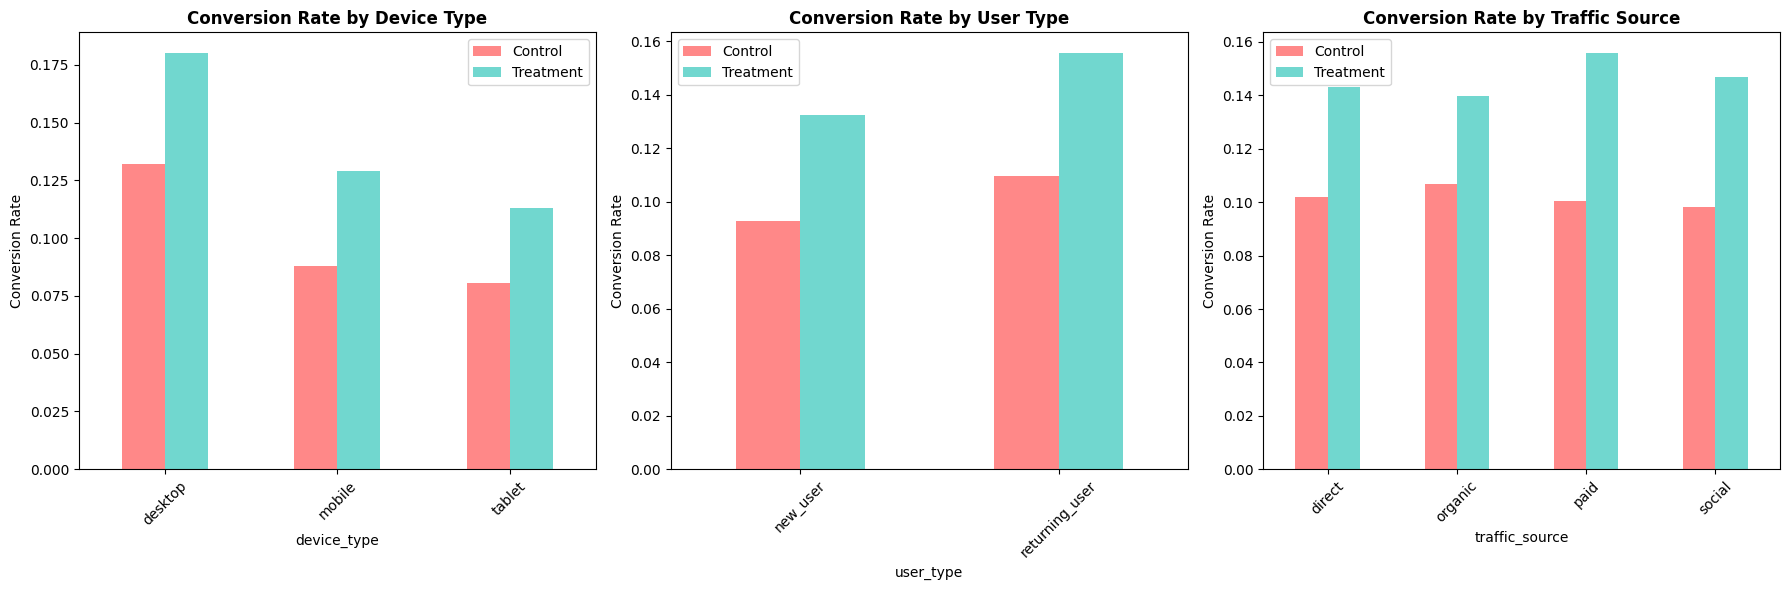

In [58]:
# Analyze different segments
device_segments = utils.segmentation_analysis(df, 'device_type')
user_segments = utils.segmentation_analysis(df, 'user_type')
traffic_segments = utils.segmentation_analysis(df, 'traffic_source')

# Visualization of segmentation results
if not device_segments.empty:
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Device type analysis
    device_plot_data = df.groupby(['device_type', 'variant'])['converted'].mean().unstack()
    device_plot_data.plot(kind='bar', ax=axes[0], color=['#FF6B6B', '#4ECDC4'], alpha=0.8)
    axes[0].set_title('Conversion Rate by Device Type', fontweight='bold')
    axes[0].set_ylabel('Conversion Rate')
    axes[0].legend(['Control', 'Treatment'])
    axes[0].tick_params(axis='x', rotation=45)
    
    # User type analysis
    user_plot_data = df.groupby(['user_type', 'variant'])['converted'].mean().unstack()
    user_plot_data.plot(kind='bar', ax=axes[1], color=['#FF6B6B', '#4ECDC4'], alpha=0.8)
    axes[1].set_title('Conversion Rate by User Type', fontweight='bold')
    axes[1].set_ylabel('Conversion Rate')
    axes[1].legend(['Control', 'Treatment'])
    axes[1].tick_params(axis='x', rotation=45)
    
    # Traffic source analysis
    traffic_plot_data = df.groupby(['traffic_source', 'variant'])['converted'].mean().unstack()
    traffic_plot_data.plot(kind='bar', ax=axes[2], color=['#FF6B6B', '#4ECDC4'], alpha=0.8)
    axes[2].set_title('Conversion Rate by Traffic Source', fontweight='bold')
    axes[2].set_ylabel('Conversion Rate')
    axes[2].legend(['Control', 'Treatment'])
    axes[2].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()


## 6. Recommendation

Generate comprehensive recommendations based on all analyses


In [59]:
print("FINAL RECOMMENDATIONS")
print("=" * 60)
# Decision criteria
statistical_significance = conv_p_value < 0.05
practical_significance = abs_lift > 0.02  # 2% absolute lift
business_impact_significant = annual_revenue_lift > 500000 # annual revenue impact > $500,000

criteria_met = sum([statistical_significance, practical_significance, business_impact_significant])
    
if criteria_met == 3:
    decision = "🚀 LAUNCH RECOMMENDED"
    confidence = "HIGH"
elif criteria_met == 2:
    decision = "⚠️ CAUTIOUS LAUNCH"
    confidence = "MEDIUM"
else:
    decision = "❌ DO NOT LAUNCH"
    confidence = "LOW"

print(f"DECISION: {decision}")
print(f"CONFIDENCE LEVEL: {confidence}")
print()

print("DECISION CRITERIA SCORECARD:")
criteria = [
    ("Statistical Significance", statistical_significance, f"p = {conv_p_value:.4f}"),
    ("Practical Significance", practical_significance, f"{abs_lift:.2%} lift"),
    ("Business Impact", business_impact_significant, f"${annual_revenue_lift:,.0f}")]

for criterion, met, detail in criteria:
    status = "✅ PASS" if met else "❌ FAIL"
    print(f"   {criterion:25} {status:10} ({detail})")

print(f"\n   TOTAL SCORE: {criteria_met}/{len(criteria)} criteria met")
print()

FINAL RECOMMENDATIONS
DECISION: 🚀 LAUNCH RECOMMENDED
CONFIDENCE LEVEL: HIGH

DECISION CRITERIA SCORECARD:
   Statistical Significance  ✅ PASS     (p = 0.0000)
   Practical Significance    ✅ PASS     (4.31% lift)
   Business Impact           ✅ PASS     ($888,275)

   TOTAL SCORE: 3/3 criteria met



Our A/B test of the streamlined checkout process shows strong positive results across all key metrics.\
Recommendation: LAUNCH ✅\
High confidence recommendation to implement the new checkout design based on statistical significance and business impact.

#### Expected Impact
**41.8% conversion rate improvement**  \
**888k annual revenue increase**